# <center>Предсказание цены продажи подержаного автомобиля</center>
## Знакомство с данными

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import category_encoders as ce
import warnings

from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

pio.renderers.default = 'png'
plt.style.use('seaborn-v0_8')

In [2]:
original_data = pd.read_csv('data/CAR DETAILS FROM CAR DEKHO.csv')
data = original_data.copy()
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


In [4]:
data.describe(include='object')

,name,fuel,seller_type,transmission,owner
count,4340,4340,4340,4340,4340
unique,1491,5,3,2,5
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner
freq,69,2153,3244,3892,2832


In [5]:
data.describe()

,year,selling_price,km_driven
count,4340.000000,4.340000e+03,4340.000000
mean,2013.090783,5.041273e+05,66215.777419
std,4.215344,5.785487e+05,46644.102194
min,1992.000000,2.000000e+04,1.000000
25%,2011.000000,2.087498e+05,35000.000000
50%,2014.000000,3.500000e+05,60000.000000
75%,2016.000000,6.000000e+05,90000.000000
max,2020.000000,8.900000e+06,806599.000000


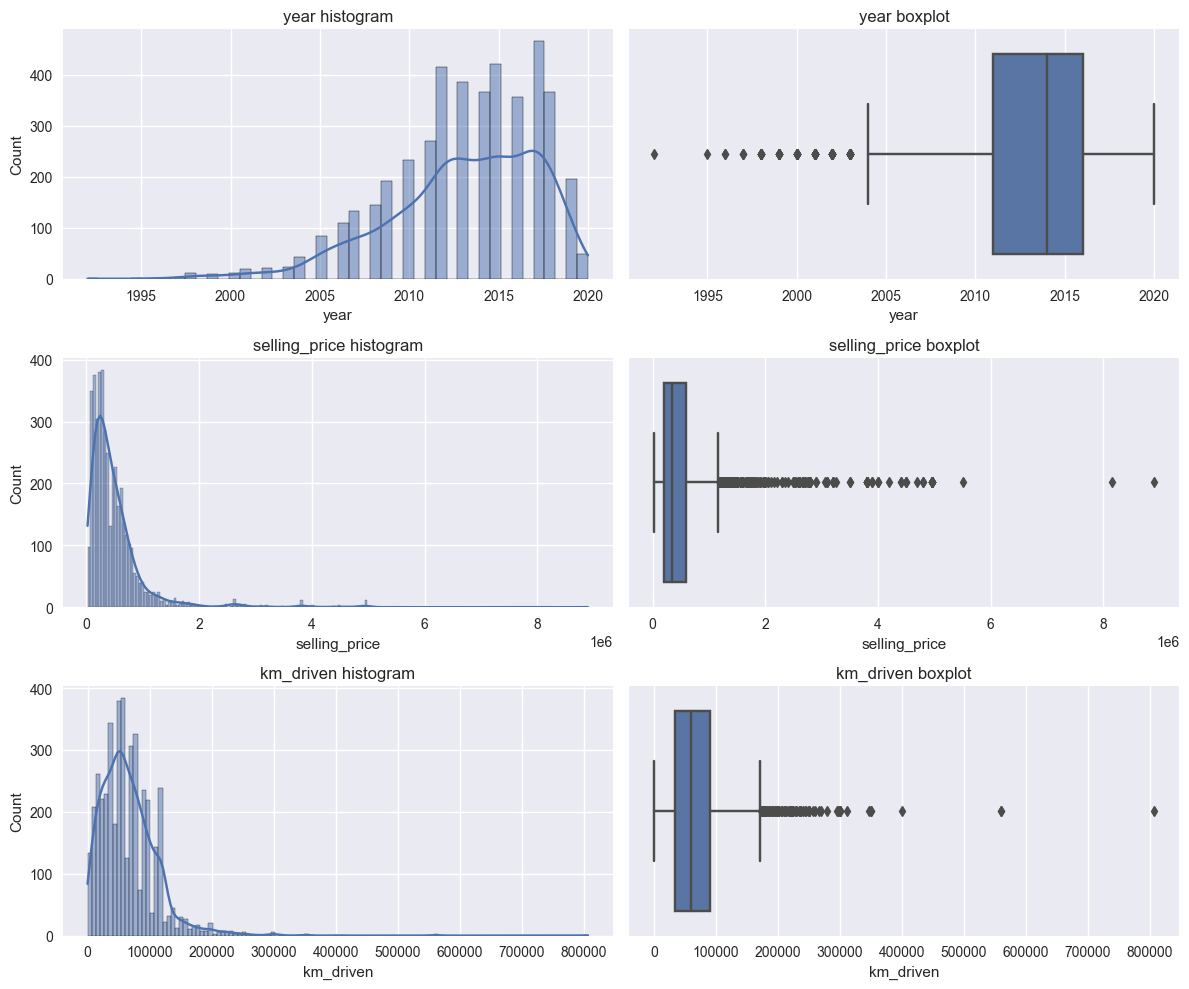

In [6]:
def make_histbox(data, features:list):
    fig, axs = plt.subplots(len(features), 2, figsize=(12, 10))
    for feature, row in zip(features, range(len(features))):
        ax, ay = axs[row, 0], axs[row, 1]
        sns.histplot(data, x=feature, ax=ax, kde=True)
        sns.boxplot(data, x=feature, ax=ay)
        ax.set_title(feature + ' histogram')
        ay.set_title(feature + ' boxplot')
    fig.tight_layout()
num_cols = [col for col in data.columns if data[col].dtype != 'object']
make_histbox(data, num_cols)

# Предобработка данных

In [7]:
data['name'].sample(20)

104                    Maruti SX4 Zxi BSIII
4187                   Hyundai Verna 1.6 SX
3913               Fiat Linea T Jet Emotion
2239                BMW X5 xDrive 30d xLine
2001                   Maruti Alto LX BSIII
2661                    Chevrolet Optra 1.6
3934                   Honda City i-DTEC ZX
2452               Maruti Swift 1.3 VXI ABS
2113                    Maruti Alto 800 LXI
2355                   Toyota Etios Liva GD
4256        Hyundai Grand i10 1.2 CRDi Asta
845      Mahindra KUV 100 mFALCON D75 K8 AW
393                   Tata Safari Storme VX
15                     Hyundai Verna 1.6 SX
3592                 Maruti Swift Dzire VDI
1432       Hyundai Grand i10 Nios AMT Magna
702                  Hyundai i20 1.2 Sportz
1330    Skoda Superb Elegance 2.0 TDI CR AT
2769                Nissan Terrano XL 85 PS
49                 Maruti Wagon R VXI BS IV
Name: name, dtype: object

In [8]:
data['car_manufacturer'] = data['name'].apply(lambda name: name.split()[0])
data.sample(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,car_manufacturer
1403,Maruti Swift VDI BSIV,2014,370000,57000,Diesel,Individual,Manual,Second Owner,Maruti
3231,Tata Indica Vista Aqua 1.4 TDI,2010,125000,81000,Diesel,Individual,Manual,Second Owner,Tata
3770,Ford Ecosport 1.5 DV5 MT Titanium,2015,650000,68000,Diesel,Individual,Manual,First Owner,Ford
2875,Maruti Swift Dzire VDI,2019,650000,20000,Diesel,Individual,Manual,First Owner,Maruti
111,Renault KWID RXT,2017,315000,16000,Petrol,Individual,Manual,First Owner,Renault
1421,Toyota Innova 2.5 E 8 STR,2012,287000,70000,Diesel,Individual,Manual,First Owner,Toyota
3040,Skoda Laura L n K 1.9 PD,2006,500000,75000,Diesel,Individual,Manual,Second Owner,Skoda
3181,Maruti 800 AC,2013,100000,80000,Petrol,Individual,Manual,First Owner,Maruti
3833,Mahindra TUV 300 T4 Plus,2017,650000,60000,Diesel,Individual,Manual,First Owner,Mahindra
2651,Maruti Alto LXi BSIII,2006,135000,90000,Petrol,Individual,Manual,Third Owner,Maruti


In [9]:
data.drop(columns='name', inplace=True)

## Визуализация зависимостей в данных

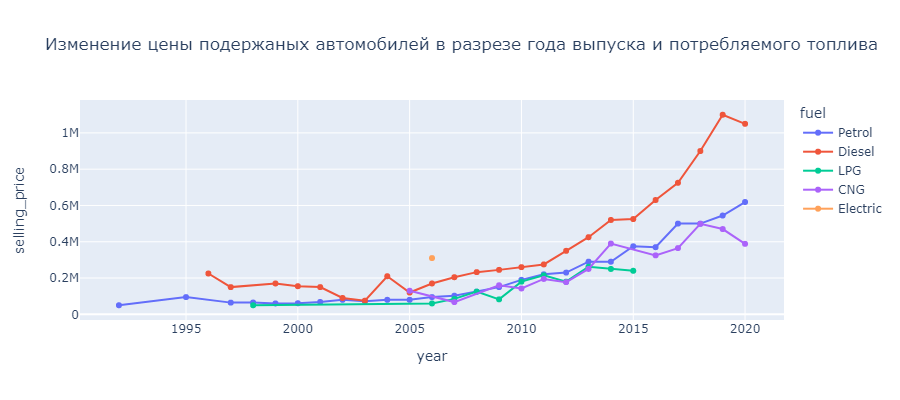

In [10]:
grouped_by_year = data.groupby(['year', 'fuel'], as_index=False)[['selling_price']].median()
px.line(
    grouped_by_year,
    x='year',
    y='selling_price',
    color='fuel',
    width=900,
    height=400,
    markers=True,
    title='Изменение цены подержаных автомобилей в разрезе года выпуска и потребляемого топлива'
).show()

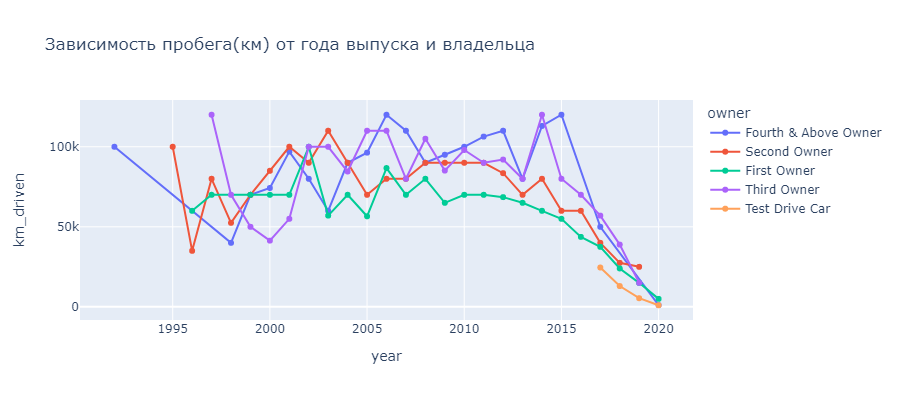

In [11]:
grouped_by_owner = data.groupby(['year', 'owner'], as_index=False)['km_driven'].median()
px.line(
    grouped_by_owner,
    x='year',
    y='km_driven',
    color='owner',
    width=900,
    height=400,
    markers=True,
    title='Зависимость пробега(км) от года выпуска и владельца'
).show()

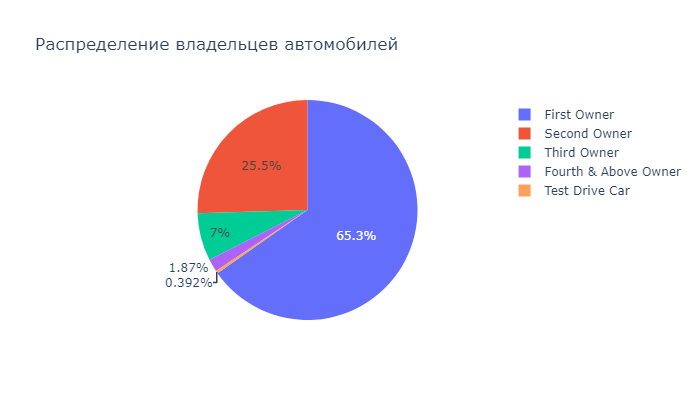

In [12]:
px.pie(
    data,
    names='owner',
    width=700,
    height=400,
    title='Распределение владельцев автомобилей'
)

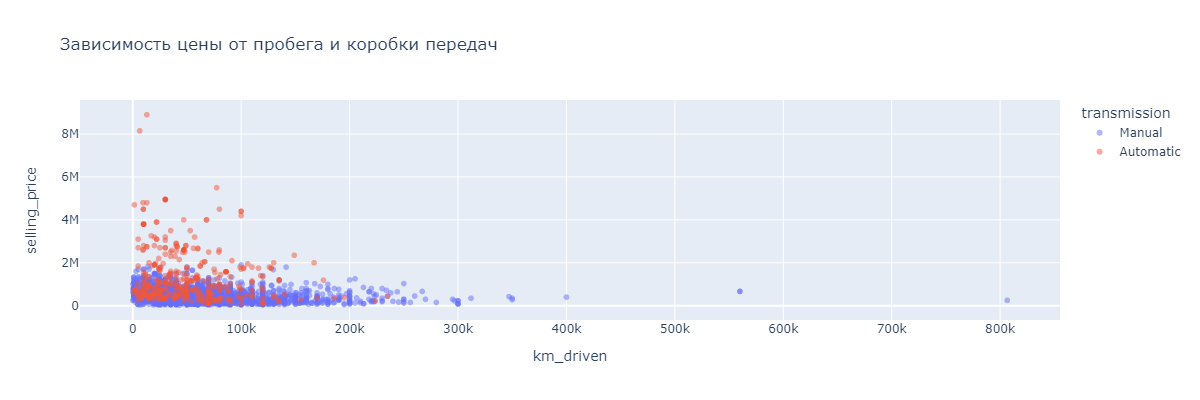

In [13]:
px.scatter(
    data,
    x='km_driven',
    y='selling_price',
    opacity=0.5,
    color='transmission',
    title='Зависимость цены от пробега и коробки передач',
    height=400,
    width=1200
)

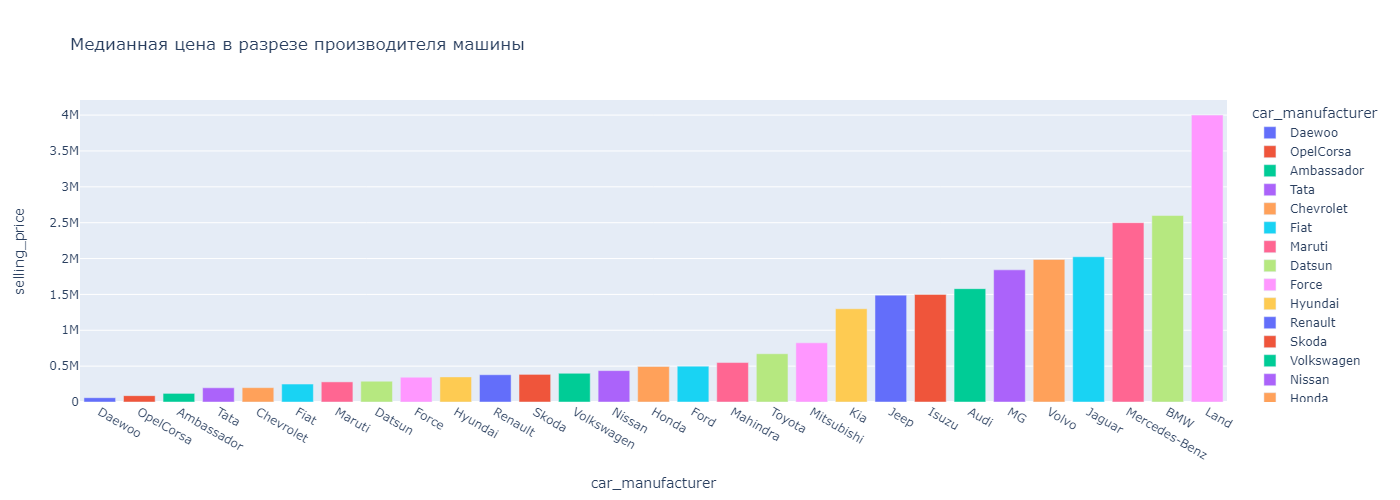

In [14]:
grouped_by_manufact = data.groupby(['car_manufacturer'], as_index=False)['selling_price'].median().sort_values(by='selling_price')
px.bar(
    grouped_by_manufact,
    x='car_manufacturer',
    y='selling_price',
    color='car_manufacturer',
    width=1400,
    height=500,
    title='Медианная цена в разрезе производителя машины'
)

## EDA

In [15]:
data.head()

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,car_manufacturer
0,2007,60000,70000,Petrol,Individual,Manual,First Owner,Maruti
1,2007,135000,50000,Petrol,Individual,Manual,First Owner,Maruti
2,2012,600000,100000,Diesel,Individual,Manual,First Owner,Hyundai
3,2017,250000,46000,Petrol,Individual,Manual,First Owner,Datsun
4,2014,450000,141000,Diesel,Individual,Manual,Second Owner,Honda


In [16]:
oh_encoder = ce.OneHotEncoder(use_cat_names=True)
bin_encoder = ce.BinaryEncoder()

oh_encoded = oh_encoder.fit_transform(data[['fuel', 'seller_type', 'owner']])
bin_encoded = bin_encoder.fit_transform(data['car_manufacturer'])
data['transmission'] = data['transmission'].apply(lambda trans: int('Manual' in trans))
num_cols.append('transmission')
encoded_cats = pd.concat([oh_encoded, bin_encoded], axis=1)
encoded_data = pd.concat([data[num_cols], encoded_cats], axis=1)
encoded_data.head()

,year,selling_price,km_driven,transmission,fuel_Petrol,fuel_Diesel,fuel_CNG,fuel_LPG,fuel_Electric,seller_type_Individual,...,owner_First Owner,owner_Second Owner,owner_Fourth & Above Owner,owner_Third Owner,owner_Test Drive Car,car_manufacturer_0,car_manufacturer_1,car_manufacturer_2,car_manufacturer_3,car_manufacturer_4
0,2007,60000,70000,1,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,2007,135000,50000,1,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
2,2012,600000,100000,1,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
3,2017,250000,46000,1,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,1
4,2014,450000,141000,1,0,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


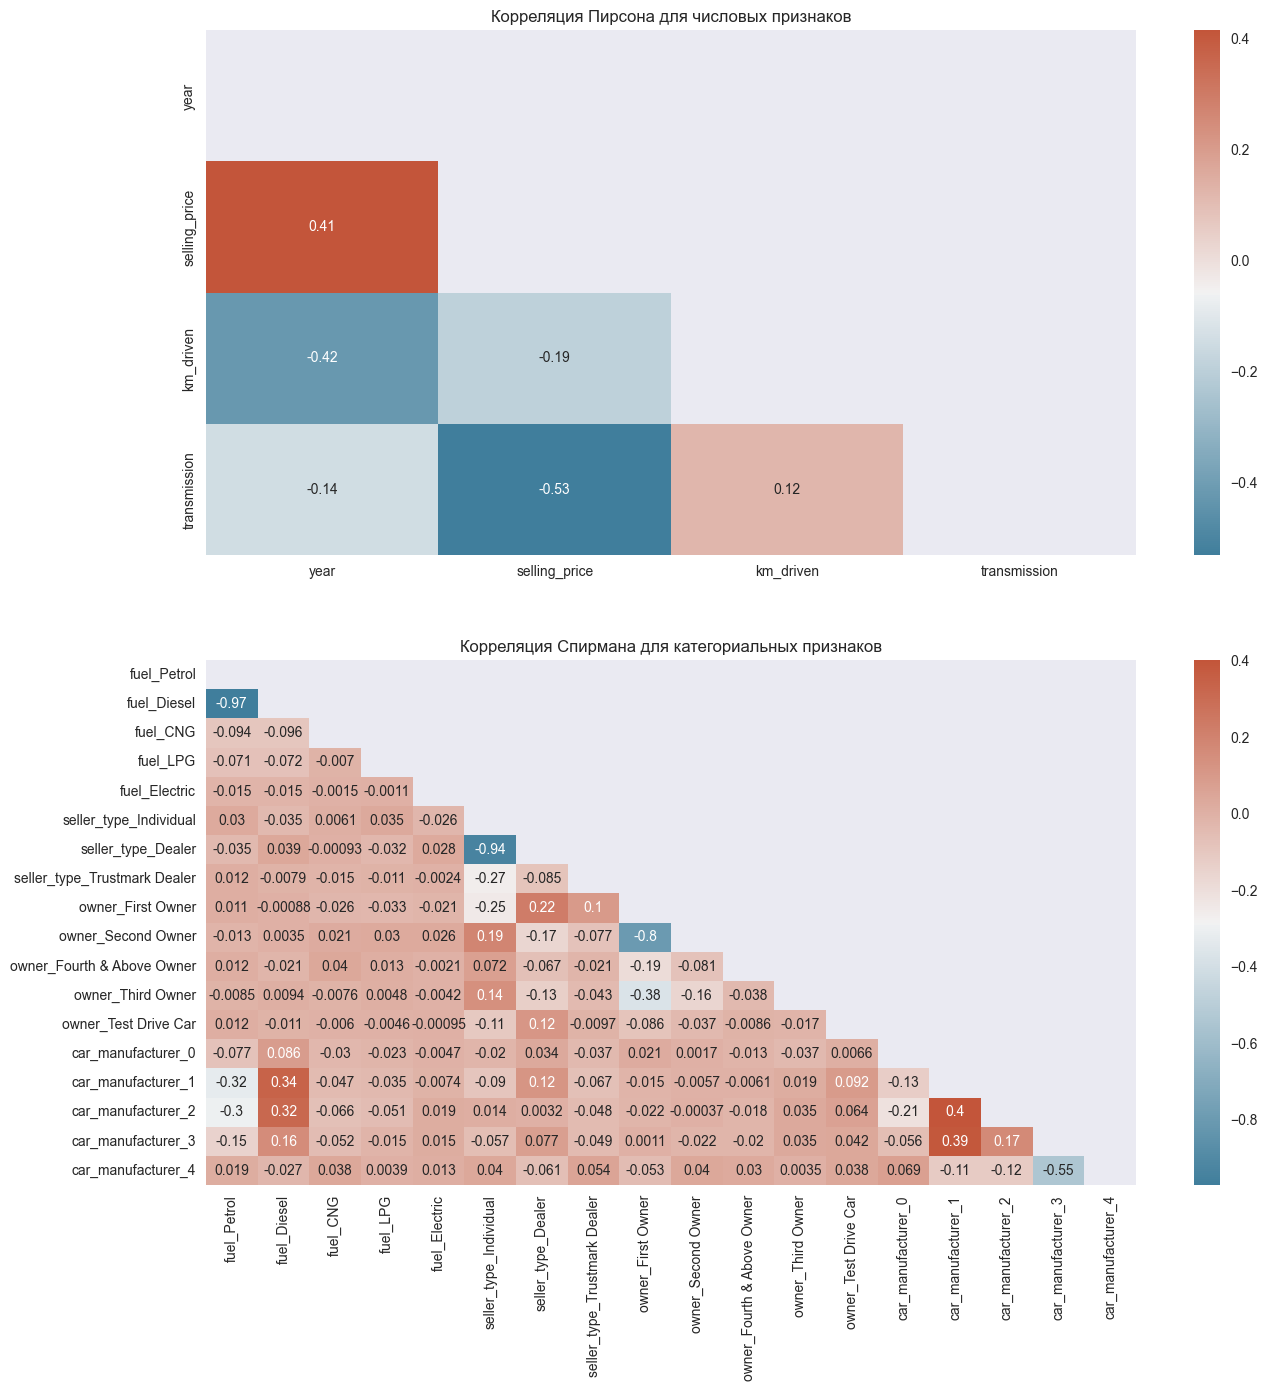

In [17]:
fig, ax = plt.subplots(2, figsize=(15, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask_num = np.triu(np.ones_like(data[num_cols].corr()))
mask_cat = np.triu(np.ones_like(encoded_cats.corr(method='spearman')))
sns.heatmap(data[num_cols].corr(), annot=True, ax=ax[0], cmap=cmap, mask=mask_num)
sns.heatmap(encoded_cats.corr(method='spearman'), annot=True, ax=ax[1], cmap=cmap, mask=mask_cat)
ax[0].set_title('Корреляция Пирсона для числовых признаков')
ax[1].set_title('Корреляция Спирмана для категориальных признаков');

In [18]:
drop_cols = ['fuel_Diesel', 'seller_type_Dealer']
encoded_data.drop(columns=drop_cols, inplace=True)
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   year                          4340 non-null   int64
 1   selling_price                 4340 non-null   int64
 2   km_driven                     4340 non-null   int64
 3   transmission                  4340 non-null   int64
 4   fuel_Petrol                   4340 non-null   int64
 5   fuel_CNG                      4340 non-null   int64
 6   fuel_LPG                      4340 non-null   int64
 7   fuel_Electric                 4340 non-null   int64
 8   seller_type_Individual        4340 non-null   int64
 9   seller_type_Trustmark Dealer  4340 non-null   int64
 10  owner_First Owner             4340 non-null   int64
 11  owner_Second Owner            4340 non-null   int64
 12  owner_Fourth & Above Owner    4340 non-null   int64
 13  owner_Third Owner             434

## Создание модели линейной регрессии

In [19]:
# Разбиваем выборку на трейн и тест
X, y = encoded_data.drop(columns='selling_price'), encoded_data['selling_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_test.shape)

(3038, 19) (1302,)


In [20]:
# Обучаем модель на данных
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, np.log(y_train))

# Делаем предсказания
y_train_predict = np.exp(lr_model.predict(X_train))
y_test_predict = np.exp(lr_model.predict(X_test))

# Рассчитываем метрики
print('Train:')
print('MAPE:', metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100)
print('R2:', metrics.r2_score(y_train, y_train_predict))
print()
print('Test:')
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100)
print('R2:', metrics.r2_score(y_test, y_test_predict))

Train:
MAPE: 37.342485306053995
R2: 0.5609751206893232

Test:
MAPE: 38.644822627011656
R2: 0.5034782902385071


In [21]:
lr_model.coef_

array([ 1.13380040e-01, -3.61538919e-07, -7.21323043e-01, -4.60105661e-01,
       -5.41224494e-01, -5.67990826e-01, -1.51353206e-01, -1.23405613e-01,
        4.07624684e-01,  3.13777358e-02, -1.19732147e-03, -1.09372093e-01,
       -7.47045693e-02,  1.53896248e-01, -4.65606222e-04,  2.55910690e-01,
       -6.28919073e-02,  6.71759471e-03, -7.43507489e-02])

У модели слишком большое смещение, попробуем его уменьшить, добавив полиномиальные признаки 2-й степени, а чтобы избежать переобучения, используем регуляризацию.

In [22]:
# Нормализуем данные перед созданием полиномиальных признаков
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)
# Создадим полиномиальные признаки
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)
print(X_train_scaled_poly.shape)

(3038, 209)


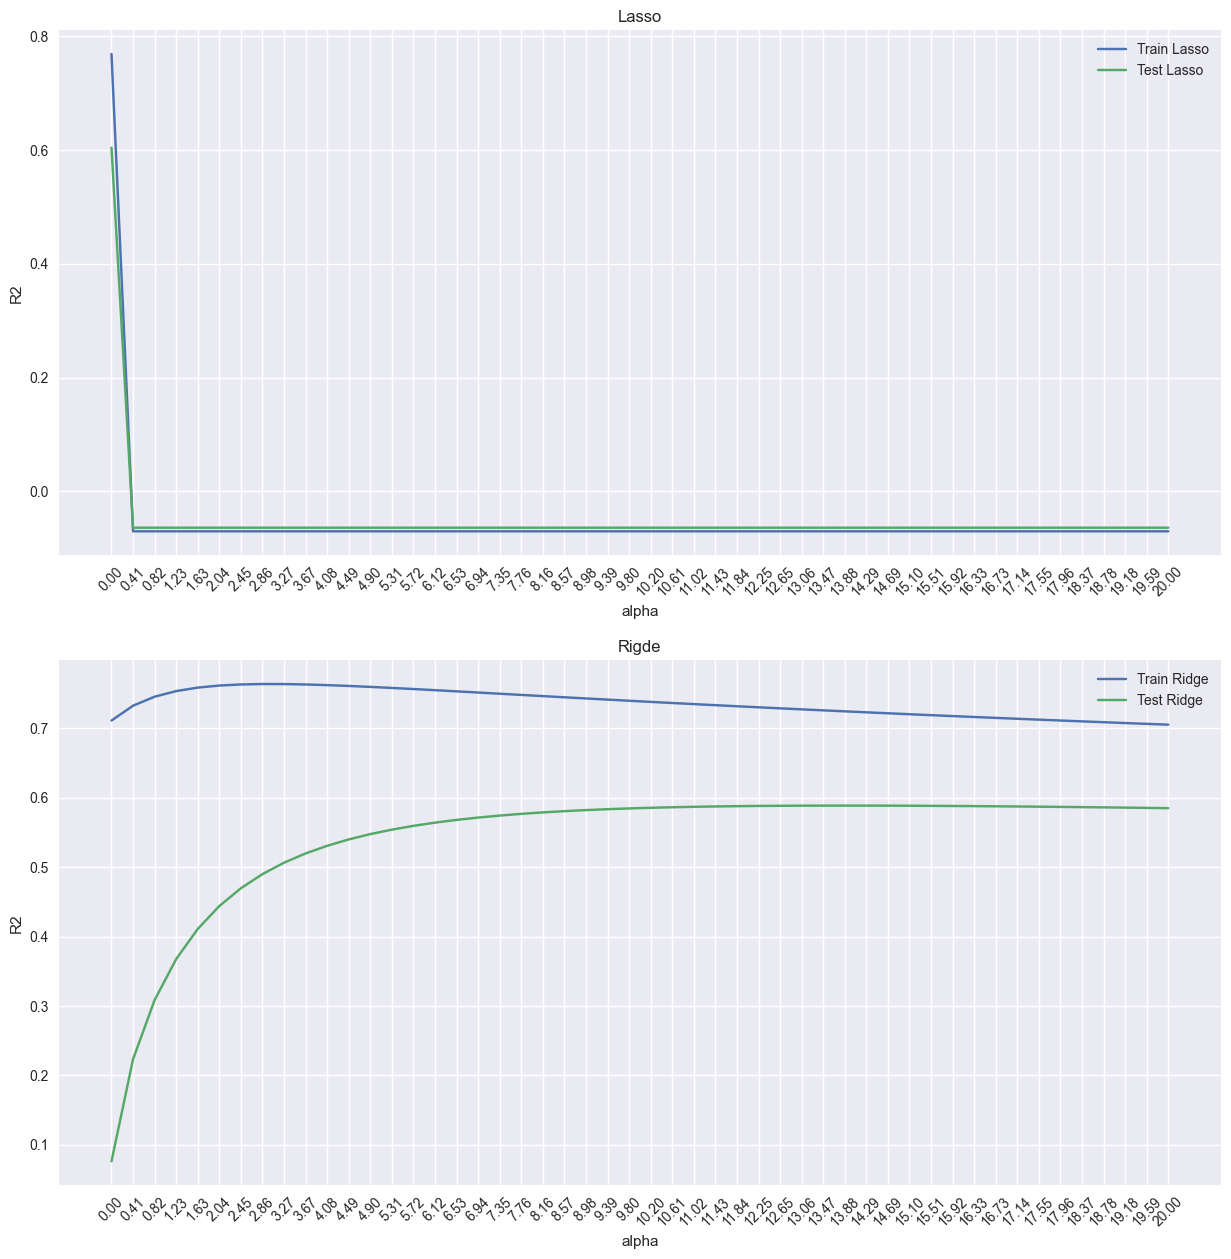

In [23]:
# Найдем оптимальное значение alpha для L1 и L2, а затем сравним их
alpha_list = np.linspace(1e-3, 20, 50)
train_score_lasso, test_score_lasso = [], []
train_score_ridge, test_score_ridge = [], []
for alpha in alpha_list:
    lasso = linear_model.Lasso(alpha=alpha, max_iter=10000)
    ridge = linear_model.Ridge(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled_poly, np.log(y_train))
    ridge.fit(X_train_scaled_poly, np.log(y_train))
    
    y_train_lasso, y_test_lasso = lasso.predict(X_train_scaled_poly), lasso.predict(X_test_scaled_poly)
    y_train_ridge, y_test_ridge = ridge.predict(X_train_scaled_poly), ridge.predict(X_test_scaled_poly)
    
    train_score_lasso.append(metrics.r2_score(y_train, np.exp(y_train_lasso)))
    test_score_lasso.append(metrics.r2_score(y_test, np.exp(y_test_lasso)))
    train_score_ridge.append(metrics.r2_score(y_train, np.exp(y_train_ridge)))
    test_score_ridge.append(metrics.r2_score(y_test, np.exp(y_test_ridge)))
    
fig, axes = plt.subplots(2, figsize=(15, 15))
sns.lineplot(
    x=alpha_list,
    y=train_score_lasso,
    label='Train Lasso',
    ax=axes[0]
)
sns.lineplot(
    x=alpha_list,
    y=test_score_lasso,
    label='Test Lasso',
    ax=axes[0]
)
sns.lineplot(
    x=alpha_list,
    y=train_score_ridge,
    label='Train Ridge',
    ax=axes[1]
)
sns.lineplot(
    x=alpha_list,
    y=test_score_ridge,
    label='Test Ridge',
    ax=axes[1]
)
axes[0].set_xticks(alpha_list)
axes[0].xaxis.set_tick_params(rotation=45)
axes[1].set_xticks(alpha_list)
axes[1].xaxis.set_tick_params(rotation=45)
axes[0].set_title('Lasso')
axes[1].set_title('Rigde')
axes[0].set_xlabel('alpha')
axes[0].set_ylabel('R2')
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('R2');